# Imports

In [255]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from sklearn.metrics import f1_score

# Utils

In [256]:

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    # Show the image
    plt.imshow(image, cmap=plt.cm.gray)
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])
    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.show()
    
    
def calculate_f1_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Calculate the F1 score between the ground truth and the prediction.

    Parameters:
    - ground_truth (np.ndarray): The ground truth binary image (edges marked with 1).
    - prediction (np.ndarray): The predicted edge binary image.

    Returns:
    - float: The F1 score as a float between 0 and 1, where 1 represents perfect agreement.
    """
    # Flatten arrays to 1D for compatibility with f1_score function
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()
    
    # Calculate and return F1 score
    return f1_score(ground_truth_flat, prediction_flat)

# Preprocessing

In [327]:
image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
images = [image1, image2, image3]

# Load the images in color
color_image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_COLOR) 
color_image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_COLOR)
color_image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_COLOR)
color_images = [color_image1, color_image2, color_image3]

ground_truth1 = cv2.imread("images/cells/9343 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth2 = cv2.imread("images/cells/10905 JL Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth3 = cv2.imread("images/cells/43590 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

def preprocess_ground_truth(image: np.ndarray):
    # Create a new array where True is set for elements that are 0 in the original image, and False otherwise
    mask = image == 0
    # Convert the boolean mask to integer (1 for True, 0 for False)
    preprocessed_image = mask.astype(int)
    return preprocessed_image

ground_truth1 = preprocess_ground_truth(ground_truth1)
ground_truth2 = preprocess_ground_truth(ground_truth2)
ground_truth3 = preprocess_ground_truth(ground_truth3)
ground_truth_images = [ground_truth1, ground_truth2, ground_truth3]

# Open the GIF image
gif_image = Image.open('images/shakey.150.gif')
# Let's just take the first frame (index 0) for the static PNG
gif_image.seek(0) 
# Save the current frame as PNG
gif_image.save('images/shakey.png')
# Import PNG
shakey_image = cv2.imread("images/shakey.png", cv2.IMREAD_GRAYSCALE)

def unsharp_masking(image, kernel_size=(3,3), sigma=2, weight_original=5, weight_edges=3, gamma=2):
    gaussian_blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    edges = cv2.subtract(image, gaussian_blurred)
    enhanced_image = cv2.addWeighted(image, weight_original, edges, weight_edges, gamma)
    return enhanced_image

def apply_top_hat_transform(image, kernel_size: int = 112):
    # Create an elliptical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Apply the Top-hat transformation to the image
    enhanced_image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    return enhanced_image

# Function to apply high-pass filter directly to an image array
def apply_high_pass_filter(image):
    image = unsharp_masking(image)
    # Apply Gaussian blur to create a low-pass filter effect
    blurred_image = cv2.GaussianBlur(image, (49, 49), 8)
    # Subtract the blurred (low-pass filtered) image from the original to get high-pass filtered image
    high_pass_filtered_image = cv2.subtract(image, blurred_image)
    return high_pass_filtered_image

# Edge Detectors

In [333]:
roberts_x = np.array([[1, 0],
                     [0, -1]])

roberts_y = np.array([[0, 1],
                      [-1, 0]])

sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = sobel_x.T 

def gaussian_kernel(size: int = 3, sigma: float = 1.0) -> np.ndarray: 
    """
    Generates a Gaussian kernel matrix for applying a Gaussian blur filter. 
    The kernel generated is a square matrix of dimensions size x size, 
    centered around the matrix origin, with values computed from the 2D Gaussian function.

    Parameters:
    - size (int, optional): The size of one side of the square Gaussian kernel. Must be a positive odd integer
      to ensure the kernel has a center. Defaults to 9, resulting in a 9x9 kernel.
    - sigma (float, optional): The standard deviation of the Gaussian distribution used in the
      kernel's calculation. This controls the spread of the blur; a larger sigma results in a blurrier image.
      Defaults to 2.0. 

    Returns:
    - np.ndarray: A 2D Numpy array of shape (size, size) containing the Gaussian kernel. The values
      are of type `np.float64`, ensuring high precision for the calculations. The kernel is normalized so that
      its sum equals 1, making it suitable for convolution operations without altering the image brightness.
   """ 

    size = int(size) // 2  # Ensuring the kernel size is effectively odd
    x, y = np.mgrid[-size:size+1, -size:size+1]  # Create a grid of (x, y) coordinates
    normal = 1 / (2.0 * np.pi * sigma**2)  # Normalization constant for the Gaussian function
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal  # Compute the Gaussian function
    return g / np.sum(g)  # Normalize and return the kernel

def zero_crossing(image, thresh=175): 
    
    z_c_image = np.zeros(image.shape)
    h,w = image.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = image[y-1:y+2, x-1:x+2]
            p = image[y, x]
            maxP = patch.max()
            minP = patch.min()
            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thresh) and zeroCross:
                z_c_image[y, x] = 1
    return z_c_image

def magnitude_img(G_x: np.ndarray, G_y: np.ndarray) -> np.ndarray:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (np.ndarray): The gradient of the image in the x-direction (horizontal).
    - G_y (np.ndarray): The gradient of the image in the y-direction (vertical).

    Returns:
    - np.ndarray: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 
  
def apply_sobel_filter(image: np.ndarray, gaussian_size: int = 3, sigma: float = 1.0, threshold: int = 126) -> np.ndarray:
  image = unsharp_masking(image)
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, sobel_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, sobel_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_roberts_filter(image: np.ndarray, gaussian_size: int = 3, sigma: float = 1.0, threshold: int = 23) -> np.ndarray:
  image = unsharp_masking(image)
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, roberts_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, roberts_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_first_order_gaussian(image: np.ndarray, gaussian_size: int = 3, sigma: float = 1.5, threshold: int = 5) -> np.ndarray:
    # Create a grid of coordinates for derivative computation
    x, y = np.meshgrid(np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1),
                       np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1))
    
    # Gaussian kernel for smoothing
    g = gaussian_kernel(gaussian_size, sigma)
    
    # First-order derivatives of Gaussian
    G_x = - (x / sigma**2) * g
    G_y = - (y / sigma**2) * g
    
    image = unsharp_masking(image)
    
    # Convolve image with G_x and G_y to get horizontal and vertical gradients
    grad_x = scipy.signal.convolve2d(image, G_x, mode='same', boundary='symm')
    grad_y = scipy.signal.convolve2d(image, G_y, mode='same', boundary='symm')
    
    # Compute gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Threshold gradient magnitude to detect edges
    edge_image = magnitude >= threshold
    
    return edge_image  # Ensuring return type is consistent

laplacian_kernel = np.array([[1,1,1],
                    [1, -8, 1],
                    [1,1,1]])

def apply_laplacian_filter(image: np.ndarray, threshold: int = 132) -> np.ndarray:
  image = apply_high_pass_filter(image)
  image = scipy.signal.convolve2d(image, laplacian_kernel, mode='same')
  edge_image = zero_crossing(image, threshold)
  return edge_image

def apply_LoG_filter(image: np.ndarray, gaussian_size: int = 15, sigma: float = 3.0, threshold: int = 14) -> np.ndarray:
    # Calculate the range of x and y values
    radius = gaussian_size // 2
    x, y = np.mgrid[-radius:radius+1, -radius:radius+1]
    # Calculate the LoG
    norm = x**2 + y**2
    log = ((norm - 2.0 * sigma**2) / sigma**4) * np.exp(-norm / (2.0 * sigma**2))
    # Normalize the mask to have a sum of 0
    log -= log.mean()
    log_image = scipy.signal.convolve2d(image, log, mode='same')
    edge_image = zero_crossing(log_image, threshold)
    # return log_image, edge_image
    # return edge_image
    return log_image, edge_image

def apply_gaussian_smoothing(image):
    # Apply Gaussian Blur with a 3x3 kernel and sigma=1
    smoothed_image = cv2.GaussianBlur(image, (3, 3), 1)
    return smoothed_image

def calculate_color_gradient(image):
    # Placeholder for combined gradient magnitude
    combined_magnitude = np.zeros_like(image[:,:,0]).astype(np.float64)
    # Apply Sobel operators to each channel and combine
    for i in range(3):  # For each color channel
        grad_x = cv2.Sobel(image[:,:,i], cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image[:,:,i], cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        combined_magnitude += magnitude
    return combined_magnitude

def calculate_canny_edge(image):
    # Apply Canny edge detector
    edges = cv2.Canny(image, 100, 200) 
    return edges

def combine_gradients(canny_edges, cg):
    # Combine the gradients (simple sum in this example)
    combined = canny_edges + cg
    return combined

# Main function
def bg_cg_edge_detector(image, color_image):
    smoothed_color = apply_gaussian_smoothing(color_image)
    cg = calculate_color_gradient(smoothed_color)
    FoG_edges = apply_first_order_gaussian(image)
    edges = combine_gradients(FoG_edges, cg)
    return edges

scharr_x = np.array([[47, 0, -47], 
                    [162, 0, -162],
                    [47, 0, -47]])

scharr_y = scharr_x.T 

def otsus_thresholding(image:np.ndarray, plot: bool = False) -> np.ndarray:
    # Compute histogram with correct bin edges
    histogram_bins = np.arange(257)  # Includes an extra edge to have 256 bins
    histogram, _ = np.histogram(image.ravel(), bins=histogram_bins, range=(0, 256))
    
    # Normalize histogram
    normalized_histogram = histogram / histogram.sum()
    
    # Finding bin centers for calculating cumulative mean correctly
    bin_centers = (histogram_bins[:-1] + histogram_bins[1:]) / 2
    
    # Compute cumulative sum and cumulative mean
    cumulative_sum = np.cumsum(normalized_histogram)
    cumulative_mean = np.cumsum(bin_centers * normalized_histogram)
    
    # Initialize variables for between class variance
    between_class_variance = np.zeros(256)
    total_mean = cumulative_mean[-1]
    
    # Iterate over all possible thresholds to compute between-class variance
    for t in range(1, 256):
        probability_class1 = cumulative_sum[t]
        probability_class2 = 1 - probability_class1
        mean_class1 = cumulative_mean[t] / probability_class1 if probability_class1 > 0 else 0
        mean_class2 = (total_mean - cumulative_mean[t]) / probability_class2 if probability_class2 > 0 else 0
        
        # Calculate between-class variance
        between_class_variance[t] = probability_class1 * probability_class2 * (mean_class1 - mean_class2) ** 2
    
    # Find the threshold that maximizes the between-class variance
    optimal_threshold = np.argmax(between_class_variance)
    
    # Apply the threshold to create a binary image
    thresh = image.copy()
    thresh[image > optimal_threshold] = 255
    thresh[image <= optimal_threshold] = 0
    
    if plot:
        # Plotting
        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()  # Get current axis for the histogram
        ax1.bar(bin_centers, histogram, width=0.5, alpha=0.7)
        ax1.set_ylabel('Frequency')
        ax1.set_xlabel('Intensity Value')
        
        ax2 = ax1.twinx()  # Secondary axis for between-class variance
        ax2.plot(bin_centers, between_class_variance, color='green', linestyle=':', label='Inter-class Variance')
        ax2.set_ylabel('Inter-class Variance')
        
        # Add vertical line for optimal threshold
        ax1.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold}')
        
        plt.xlim(5, 100)
        
        # Adjusting legend
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.tight_layout()  # Adjust layout to not cut off labelss
        plt.show()

    return thresh

def apply_otsu_scharr(image: np.ndarray, color_image: np.ndarray, threshold: float = 420) -> np.ndarray: 
    
    image = apply_top_hat_transform(image)
    
    binary = otsus_thresholding(image)

    G_x = scipy.signal.convolve2d(binary, scharr_x, mode="same")
    G_y = scipy.signal.convolve2d(binary, scharr_y, mode="same")

    # Calculate the magnitude and direction of the gradient at each pixel
    magnitude_image = magnitude_img(G_x, G_y)  # Magnitude of gradient
    
    FoG_CG = bg_cg_edge_detector(image, color_image)
    print(np.max(FoG_CG))
    
    magnitude_image = FoG_CG + magnitude_image
    final_edges = magnitude_image > threshold
    

    return final_edges


# Task 1

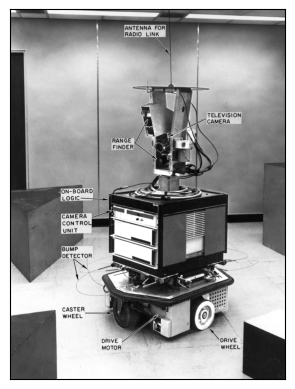

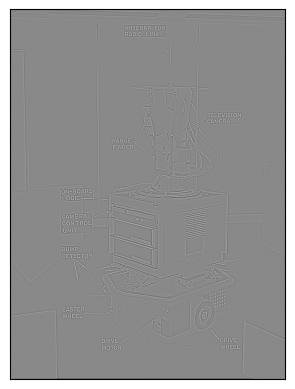

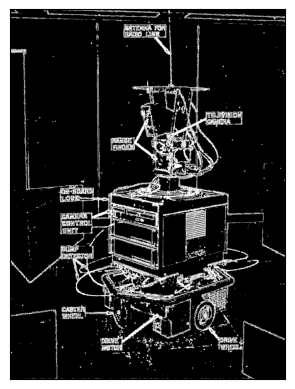

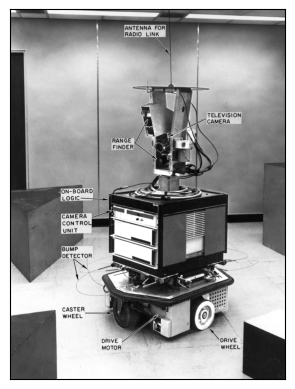

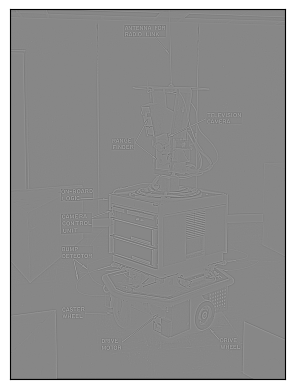

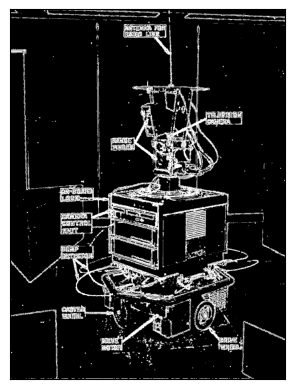

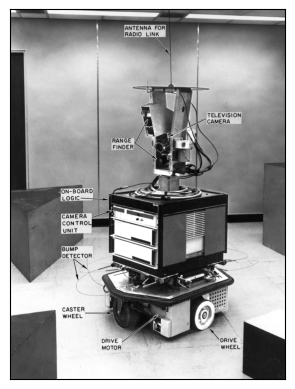

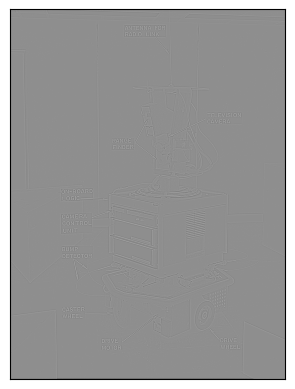

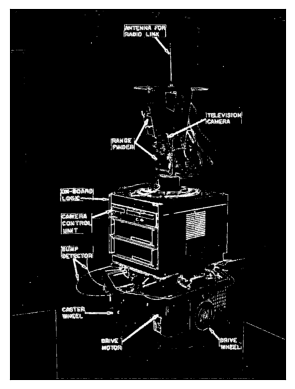

In [259]:

log_image, edge_image = apply_LoG_filter(shakey_image, gaussian_size=9, sigma=1, threshold=100)
show_binary_image(shakey_image)
show_binary_image(log_image)
show_binary_image(edge_image)


log_image, edge_image = apply_LoG_filter(shakey_image, gaussian_size=5, sigma=1, threshold=100)
show_binary_image(shakey_image)
show_binary_image(log_image)
show_binary_image(edge_image)


log_image, edge_image = apply_LoG_filter(shakey_image, gaussian_size=3, sigma=1, threshold=100)
show_binary_image(shakey_image)
show_binary_image(log_image)
show_binary_image(edge_image)

# Task 2 Grid Searching for best thresholds and gaussian filters

In [260]:


# # Define the grid search function
# def grid_search_threshold(edge_detection_fn, thresholds, images, ground_truths):
#     optimal_threshold = None
#     highest_avg_f1 = -1
    
#     for threshold in thresholds:
#         f1_scores = []
#         for image, ground_truth in zip(images, ground_truths):
#             # predicted_edges = edge_detection_fn(image, threshold=threshold)
            
#             result = edge_detection_fn(image, threshold=threshold)
#             predicted_edges = result if not isinstance(result, tuple) else result[1]

                
#             f1_score = calculate_f1_score(ground_truth, predicted_edges)
#             f1_scores.append(f1_score)
        
#         avg_f1 = np.mean(f1_scores)
#         if avg_f1 > highest_avg_f1:
#             highest_avg_f1 = avg_f1
#             optimal_threshold = threshold
#             print(f"New optimal {optimal_threshold} with f1 score: {highest_avg_f1}")
#         else:
#             break
    
#     return optimal_threshold, highest_avg_f1



# thresholds = range(130, 255, 1)  # Example: 0, 1, 2, ..., 254

# # images = [image1, image2, image3]
# images = [sharp_filter_image1, sharp_filter_image2, sharp_filter_image3]
# ground_truths = [ground_truth1, ground_truth2, ground_truth3]

# # Define edge detection functions that can accept gaussian_size and sigma parameters
# edge_detection_functions = [
#     ("Laplacian", apply_laplacian_filter),  
# ]



    
# for name, fn in edge_detection_functions:
#     optimal_threshold, highest_avg_f1 = grid_search_threshold(fn, thresholds, images, ground_truths)
#     print(f"{name} - Final Optimal Parameters: Threshold: {optimal_threshold}, Highest Avg F1 Score: {highest_avg_f1}")



In [261]:
# import numpy as np
# from sklearn.metrics import f1_score

# def grid_search_parameters(edge_detection_fn, fn_name, thresholds, gaussian_sizes, sigmas, images, ground_truths):
#     optimal_params = {
#         'threshold': None,
#         'gaussian_size': None,
#         'sigma': None
#     }
#     highest_avg_f1 = -1

#     for gaussian_size in gaussian_sizes:
#         for sigma in sigmas:
#             local_highest_f1 = -1  # Track the best F1 score for this Gaussian size and sigma combination
#             for threshold in thresholds:
#                 f1_scores = []
#                 for image, ground_truth in zip(images, ground_truths):
#                     result = edge_detection_fn(image, threshold=threshold, gaussian_size=gaussian_size, sigma=sigma)
#                     predicted_edges = result if not isinstance(result, tuple) else result[1]
#                     f1_score_value = calculate_f1_score(ground_truth, predicted_edges)
#                     f1_scores.append(f1_score_value)

#                 avg_f1 = np.mean(f1_scores)
#                 if avg_f1 > local_highest_f1:
#                     local_highest_f1 = avg_f1
#                     if avg_f1 > highest_avg_f1:
#                         highest_avg_f1 = avg_f1
#                         optimal_params['threshold'] = threshold
#                         optimal_params['gaussian_size'] = gaussian_size
#                         optimal_params['sigma'] = sigma
#                         print(f"{fn_name} - New optimal {optimal_params} with F1 score: {highest_avg_f1}")
#                     else:
#                         print(f"{fn_name} - {gaussian_size}, {sigma}, {threshold} yields F1 score: {avg_f1}, but does not improve the highest score.")
#                 else:
#                     # If the score did not improve, indicate stopping further threshold exploration for this combination
#                     print(f"{fn_name} - Stopping at {gaussian_size}, {sigma}, {threshold} with F1 score: {avg_f1} (no improvement)")
#                     break

#     return optimal_params, highest_avg_f1


# # Example usage:
# # Define the ranges for Gaussian sizes, sigmas, and thresholds
# gaussian_sizes = [3, 5, 7]
# sigmas = [1, 1.5, 2]
# thresholds = range(0, 255, 1)  # Example: 0, 1, 2, ..., 254

# ground_truths = [ground_truth1, ground_truth2, ground_truth3]

# # Define edge detection functions that can accept gaussian_size and sigma parameters

# images = [sharp_image1, sharp_image1, sharp_image1] # USE FOR SOBEL, ROBERTS, FoG
# edge_detection_functions = [
#     ("Sobel", apply_sobel_filter),  # Example, replace with your actual function definitions
#     ("Roberts", apply_roberts_filter),
#     ("First Order Gaussian", apply_first_order_gaussian),
# ]

# # images = [image1, image2, image3] # USE FOR LoG
# # edge_detection_functions = [
# #     ("LoG", apply_LoG_filter)
# # ]

# # Example usage
# # Define your thresholds, gaussian_sizes, sigmas, images, and ground_truths before using this function.

# # Example execution with your edge detection functions
# for name, fn in edge_detection_functions:
#     optimal_params, highest_avg_f1 = grid_search_parameters(fn, name, thresholds, gaussian_sizes, sigmas, images, ground_truths)
#     print(f"{name} - Final Optimal Parameters: Threshold: {optimal_params['threshold']}, Gaussian Size: {optimal_params['gaussian_size']}, Sigma: {optimal_params['sigma']}, Highest Avg F1 Score: {highest_avg_f1}")



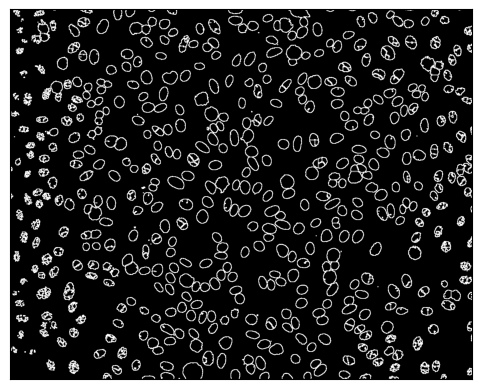

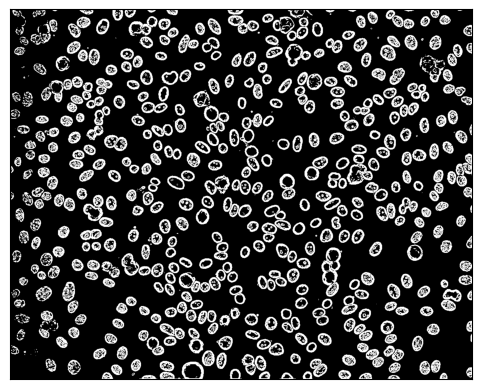

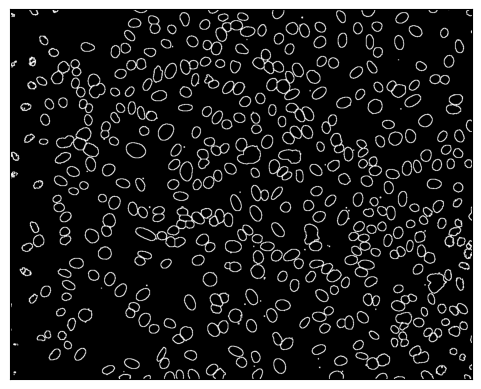

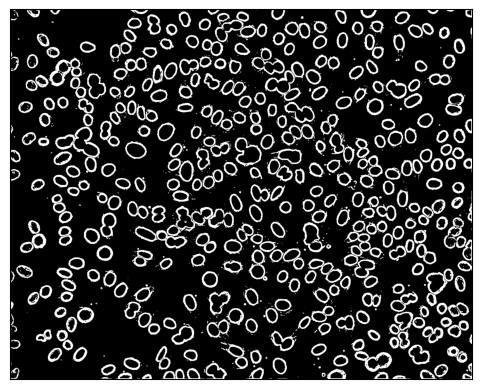

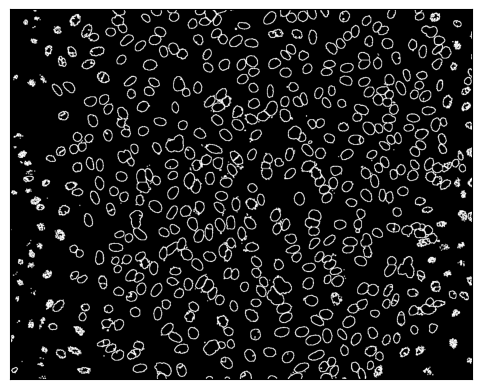

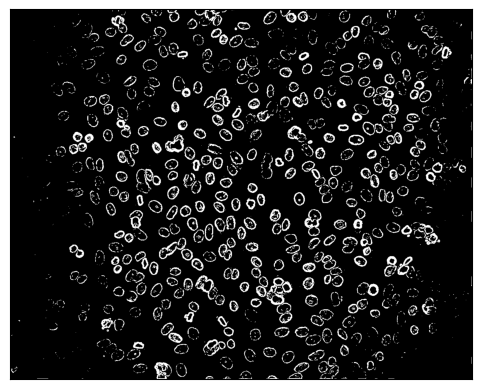

In [262]:
sobel_edge_image1 = apply_sobel_filter(image1)
sobel_edge_image2 = apply_sobel_filter(image2)
sobel_edge_image3 = apply_sobel_filter(image3)
show_binary_image(ground_truth1)
show_binary_image(sobel_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(sobel_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(sobel_edge_image3)

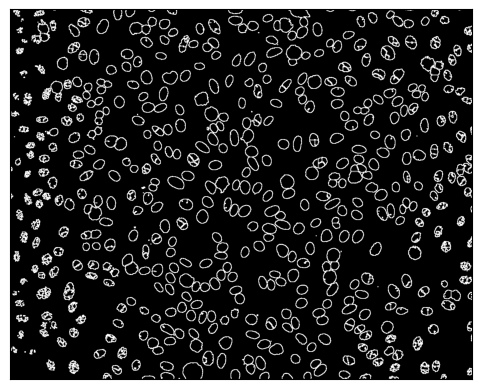

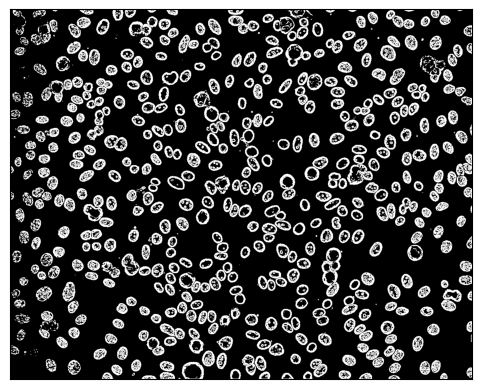

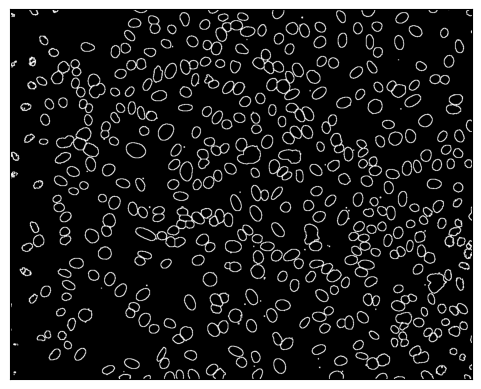

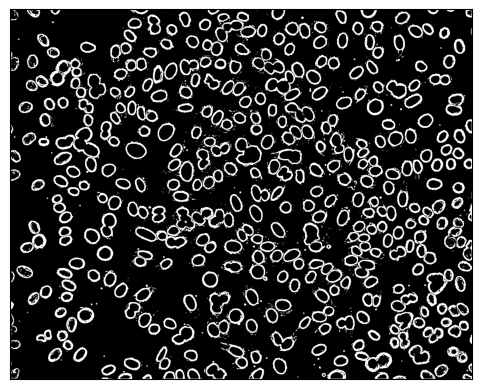

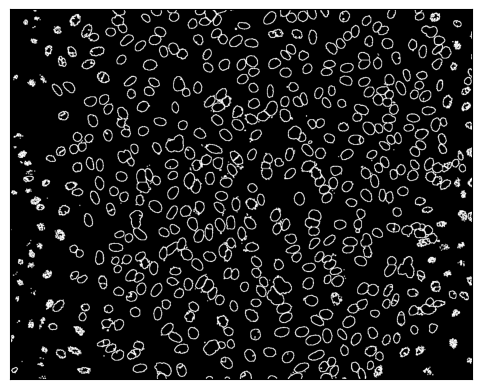

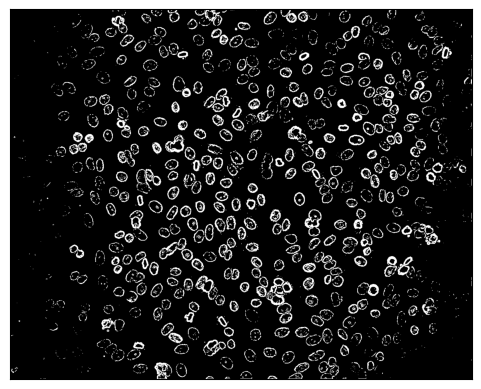

In [271]:
roberts_edge_image1 = apply_roberts_filter(image1)
roberts_edge_image2 = apply_roberts_filter(image2)
roberts_edge_image3 = apply_roberts_filter(image3)
show_binary_image(ground_truth1)
show_binary_image(roberts_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(roberts_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(roberts_edge_image3)

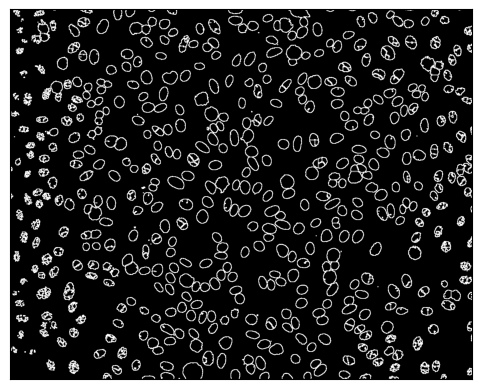

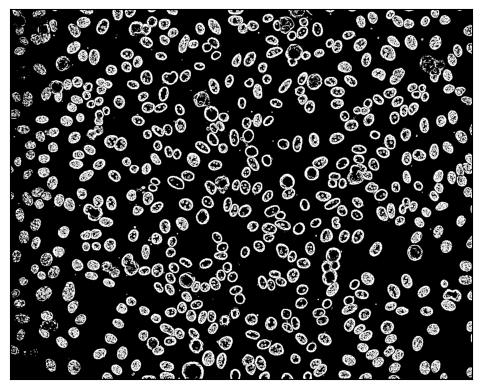

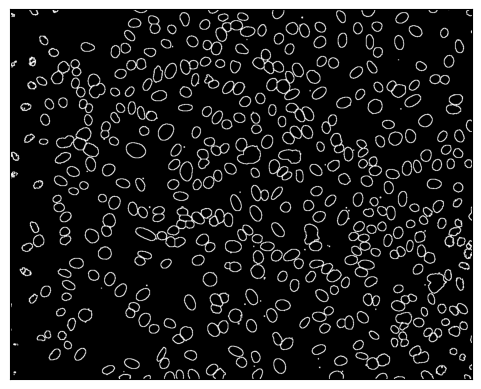

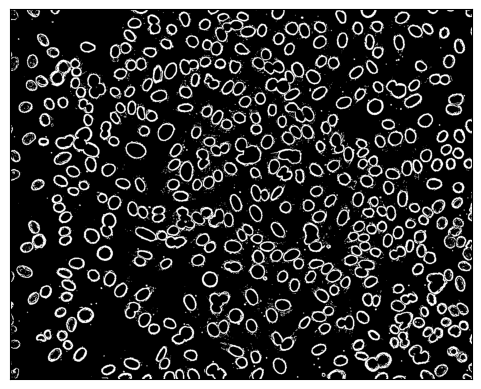

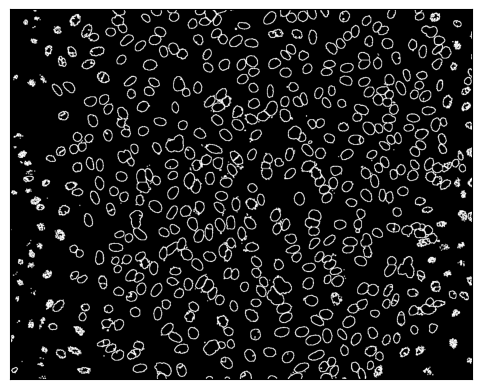

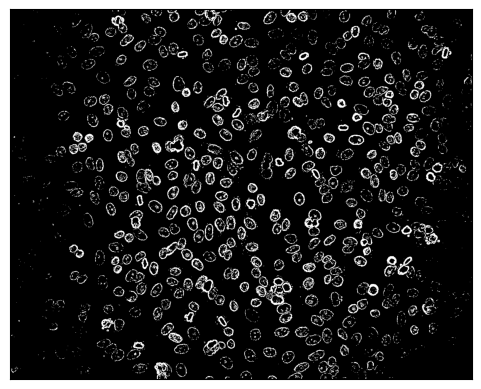

In [272]:
FoG_edge_image1 = apply_first_order_gaussian(image1)
FoG_edge_image2 = apply_first_order_gaussian(image2)
FoG_edge_image3 = apply_first_order_gaussian(image3)

show_binary_image(ground_truth1)
show_binary_image(FoG_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(FoG_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(FoG_edge_image3)

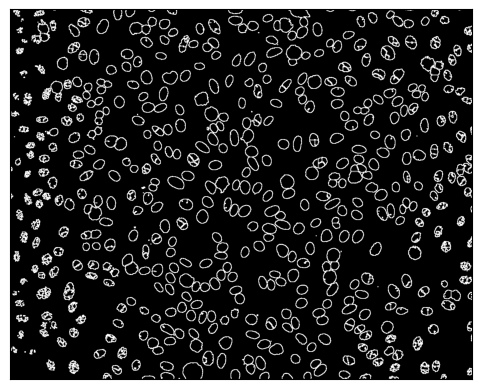

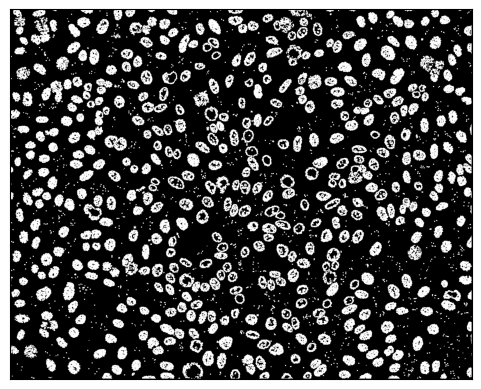

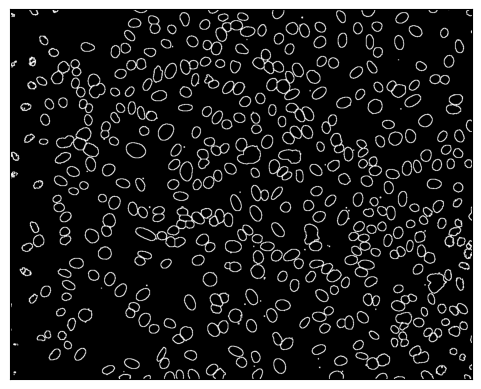

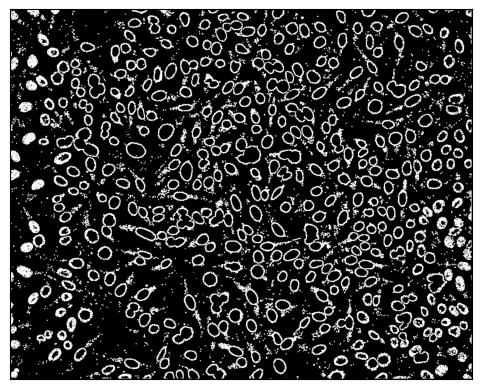

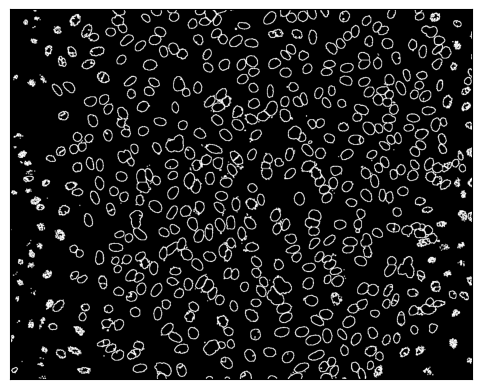

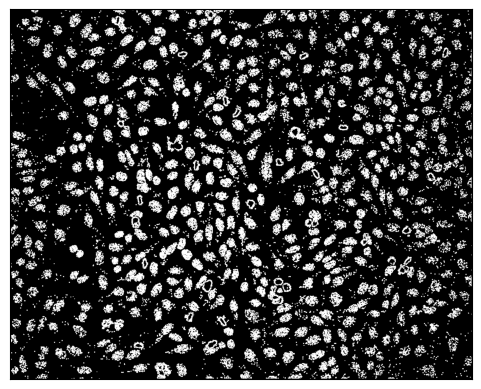

In [273]:
laplacian_edge_image1 = apply_laplacian_filter(image1)
laplacian_edge_image2 = apply_laplacian_filter(image2)
laplacian_edge_image3 = apply_laplacian_filter(image3)

show_binary_image(ground_truth1)
show_binary_image(laplacian_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(laplacian_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(laplacian_edge_image3)

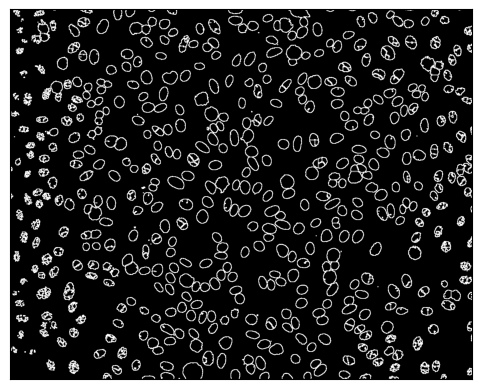

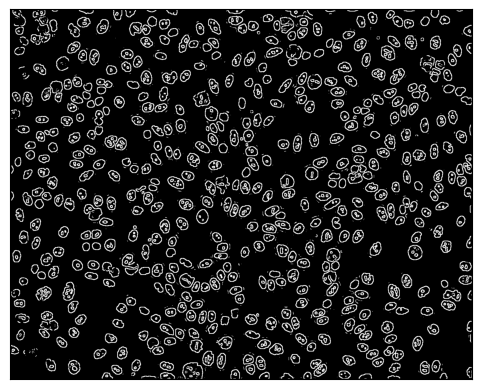

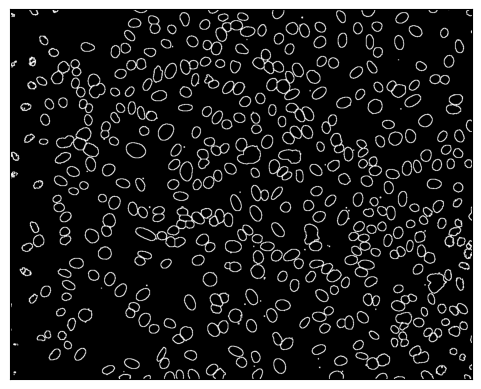

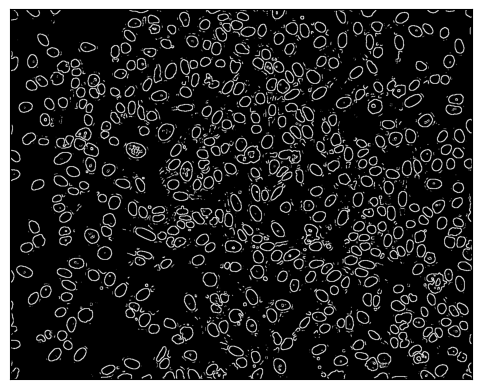

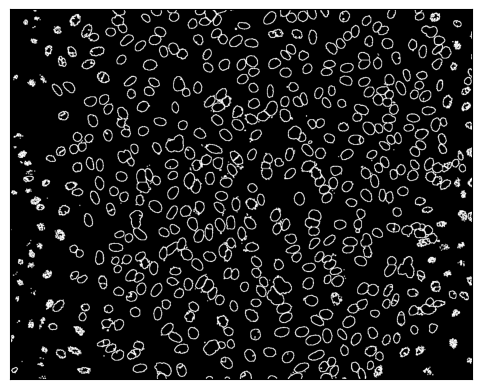

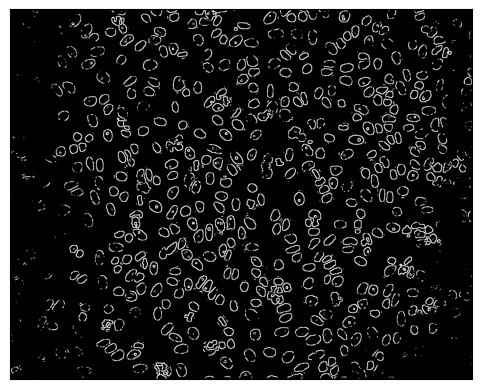

In [274]:
_, LoG_edge_image1 = apply_LoG_filter(image1)
_, LoG_edge_image2 = apply_LoG_filter(image2)
_, LoG_edge_image3 = apply_LoG_filter(image3)

show_binary_image(ground_truth1)
show_binary_image(LoG_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(LoG_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(LoG_edge_image3)

# Task 3 Bayesian Optimization for best morphological operation and thresholds

In [268]:
# import cv2
# import numpy as np
# from hyperopt import hp, fmin, tpe, Trials

# ground_truth_images = [ground_truth1, ground_truth2, ground_truth3]


# def apply_morphological_operation(image: np.ndarray, kernel_size: int, struct_element_shape: int, morph_op: int) -> np.ndarray:
#     """
#     Applies a morphological operation using a structuring element of the specified size and shape.

#     Parameters:
#     - image (np.ndarray): The input image.
#     - kernel_size (int): The size of the square kernel.
#     - struct_element_shape (int): The shape of the structuring element (cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS).
#     - morph_op (int): The morphological operation (cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE).

#     Returns:
#     - np.ndarray: The resulting image after the morphological operation.
#     """
#     # Create a deep copy of the image to ensure the original is not modified
#     image_copy = np.copy(image)

#     kernel = cv2.getStructuringElement(struct_element_shape, (kernel_size, kernel_size))
#     result = cv2.morphologyEx(image_copy, morph_op, kernel)
#     otsu_scharr_image = apply_otsu_scharr(result)  # Assumes this function does not modify its input in-place
    
#     return otsu_scharr_image

# def objective(params):
#     kernel_size = int(params['kernel_size'])
#     struct_element_shape = int(params['struct_element_shape'])
#     morph_op = int(params['morph_op'])
#     f1_scores = []
#     for image, ground_truth in zip([image1, image2, image3], ground_truth_images):
#         predicted_edges = apply_morphological_operation(image, kernel_size, struct_element_shape, morph_op)
#         f1 = calculate_f1_score(ground_truth, predicted_edges)
#         f1_scores.append(f1)
#     avg_f1 = np.mean(f1_scores)
#     return -avg_f1

# # Define the search space
# space = {
#     'kernel_size': hp.quniform('kernel_size', 1, 255, 2),
#     'struct_element_shape': hp.choice('struct_element_shape', [cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS]),
#     'morph_op': hp.choice('morph_op', [cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE])
# }

# # Run the optimization
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)

# best_kernel_size = int(best['kernel_size'])
# best_struct_element_shape = ['MORPH_RECT', 'MORPH_ELLIPSE', 'MORPH_CROSS'][best['struct_element_shape']]
# best_morph_op = ['MORPH_GRADIENT', 'MORPH_TOPHAT', 'MORPH_OPEN', 'MORPH_CLOSE'][best['morph_op']]

# print(f"Best kernel size: {best_kernel_size}, Best Structuring Element Shape: {best_struct_element_shape}, Best Morphological Operation: {best_morph_op}")

In [ ]:
# def grid_search_threshold(edge_detection_fn, thresholds, grayscale_images, color_images, ground_truths):
#     optimal_threshold = None
#     highest_avg_f1 = -1
    
#     # Ensure there's an equal number of grayscale and color images, and their corresponding ground truths
#     assert len(grayscale_images) == len(color_images) == len(ground_truths), "Mismatch in number of images and ground truths."
    
#     for threshold in thresholds:
#         f1_scores = []
#         for grayscale_image, color_image, ground_truth in zip(grayscale_images, color_images, ground_truths):
#             # Adjusted to pass both grayscale and color images
#             predicted_edges = edge_detection_fn(grayscale_image, color_image, threshold=threshold)
#             f1_score = calculate_f1_score(ground_truth, predicted_edges)
#             f1_scores.append(f1_score)
        
#         avg_f1 = np.mean(f1_scores)
#         if avg_f1 > highest_avg_f1:
#             highest_avg_f1 = avg_f1
#             optimal_threshold = threshold
#             print(f"New optimal threshold: {optimal_threshold} with F1 score: {highest_avg_f1}")s
    
#     return optimal_threshold, highest_avg_f1

# # Example usage
# thresholds = range(1, 1000, 20)  # Adjust the range as needed for your application
# # Assume grayscale_images, color_images, ground_truths, and image_paths are defined
# optimal_threshold, highest_avg_f1 = grid_search_threshold(apply_otsu_scharr, thresholds, images, color_images, ground_truth_images)
# print(f"Optimal Threshold: {optimal_threshold}, Highest Avg F1 Score: {highest_avg_f1}")


In [ ]:
otsu_scharr_image1 = apply_otsu_scharr(image1, color_image1)
otsu_scharr_image2 = apply_otsu_scharr(image2, color_image2)
otsu_scharr_image3 = apply_otsu_scharr(image3, color_image3)

show_binary_image(ground_truth1)
show_binary_image(otsu_scharr_image1)
show_binary_image(ground_truth2)
show_binary_image(otsu_scharr_image2)
show_binary_image(ground_truth3)
show_binary_image(otsu_scharr_image3)

# Task 4 Evaluation Graphs

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

def compute_metrics(ground_truth, prediction):
    
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()
    
    accuracy = accuracy_score(ground_truth, prediction)
    precision = precision_score(ground_truth, prediction)
    recall = recall_score(ground_truth, prediction)
    F1 = f1_score(ground_truth, prediction)
    MSE = mean_squared_error(ground_truth, prediction)
    
    return accuracy, precision, recall, F1, MSE


In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, otsu_scharr_image1)
print(f"OS IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, otsu_scharr_image2)
print(f"OS IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, otsu_scharr_image3)
print(f"OS IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

OS IMAGE 1: Accuracy: 0.9898719787597656
Precision: 0.9759160296196889
Recall: 0.9225262776368249
F1 Score: 0.9484704156137552
MSE: 0.010128021240234375

OS IMAGE 2: Accuracy: 0.9907196044921875
Precision: 0.9512986368777159
Recall: 0.9296614441945241
F1 Score: 0.9403555912955645
MSE: 0.0092803955078125

OS IMAGE 3: Accuracy: 0.9845436096191407
Precision: 0.9577037999898712
Recall: 0.8815330469035281
F1 Score: 0.9180411432732569
MSE: 0.015456390380859376



In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, sobel_edge_image1)
print(f"SOBEL IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, sobel_edge_image2)
print(f"SOBEL IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, sobel_edge_image3)
print(f"SOBEL IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

SOBEL IMAGE 1: Accuracy: 0.8754615783691406
Precision: 0.44235598821781325
Recall: 0.8924580161894407
F1 Score: 0.5915193373622111
MSE: 0.12453842163085938

SOBEL IMAGE 2: Accuracy: 0.900323486328125
Precision: 0.43779852366478506
Recall: 0.9384161948344063
F1 Score: 0.5970539613610008
MSE: 0.099676513671875

SOBEL IMAGE 3: Accuracy: 0.9153007507324219
Precision: 0.579881175960705
Recall: 0.49897056195663153
F1 Score: 0.5363918434163106
MSE: 0.08469924926757813



In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, roberts_edge_image1)
print(f"ROBERTS IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, roberts_edge_image2)
print(f"ROBERTS IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, roberts_edge_image3)
print(f"ROBERTS IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

ROBERTS IMAGE 1: Accuracy: 0.8735588073730469
Precision: 0.43762200399405016
Recall: 0.8819620635495953
F1 Score: 0.5849813061410516
MSE: 0.12644119262695314

ROBERTS IMAGE 2: Accuracy: 0.9023544311523437
Precision: 0.44211698697038043
Recall: 0.9198111378267276
F1 Score: 0.5971888258028779
MSE: 0.09764556884765625

ROBERTS IMAGE 3: Accuracy: 0.9069801330566406
Precision: 0.5302183126179707
Recall: 0.46267995742399637
F1 Score: 0.4941521074402453
MSE: 0.09301986694335937



In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, FoG_edge_image1)
print(f"FoG IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, FoG_edge_image2)
print(f"FoG IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, FoG_edge_image3)
print(f"FoG IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

FoG IMAGE 1: Accuracy: 0.8851646423339844
Precision: 0.4642740026945126
Recall: 0.8873308565905521
F1 Score: 0.6095933225951201
MSE: 0.11483535766601563

FoG IMAGE 2: Accuracy: 0.9177253723144532
Precision: 0.48797233252209554
Recall: 0.9233692701465912
F1 Score: 0.6385111239981363
MSE: 0.08227462768554687

FoG IMAGE 3: Accuracy: 0.9115066528320312
Precision: 0.5644316581743772
Recall: 0.43290006293168415
F1 Score: 0.48999243716692753
MSE: 0.08849334716796875



In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, laplacian_edge_image1)
print(f"LAPLACIAN IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, laplacian_edge_image2)
print(f"LAPLACIAN IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, laplacian_edge_image3)
print(f"LAPLACIAN IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

LAPLACIAN IMAGE 1: Accuracy: 0.8392608642578125
Precision: 0.3652658112770925
Recall: 0.8009469010511054
F1 Score: 0.5017241134651134
MSE: 0.1607391357421875

LAPLACIAN IMAGE 2: Accuracy: 0.8910606384277344
Precision: 0.41159943808950433
Recall: 0.8948169549367874
F1 Score: 0.5638419080026513
MSE: 0.10893936157226562

LAPLACIAN IMAGE 3: Accuracy: 0.7976242065429687
Precision: 0.22862650793966255
Recall: 0.4468848816340484
F1 Score: 0.3024959505227507
MSE: 0.20237579345703124



In [ ]:
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, LoG_edge_image1)
print(f"LoG IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, LoG_edge_image2)
print(f"LoG IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, LoG_edge_image3)
print(f"LoG IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

LoG IMAGE 1: Accuracy: 0.9085617065429688
Precision: 0.5413968730259002
Recall: 0.6212622326930047
F1 Score: 0.5785864978902954
MSE: 0.09143829345703125

LoG IMAGE 2: Accuracy: 0.9301475524902344
Precision: 0.5450305851994062
Recall: 0.6798456526797487
F1 Score: 0.605018960228817
MSE: 0.06985244750976563

LoG IMAGE 3: Accuracy: 0.9233894348144531
Precision: 0.651415912155654
Recall: 0.4728966444204458
F1 Score: 0.5479835605832122
MSE: 0.07661056518554688

